In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'


num GPUs 0


# 1. Load a test image from a dataset (now : CelebA 128x128)

Dimensions of input image: (3, 128, 128)


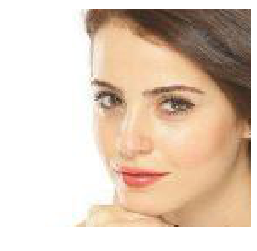

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '1' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
if dataset == 'celeba':
    #img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
    cx=89
    cy=121
    img_pil = img_pil.crop((cx-64, cy - 64, cx + 64, cy+64))

img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)


img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')

save_path= 'Original'+'_'+img_name+'.png'
plt.savefig(save_path, bbox_inches='tight', pad_inches = 0)

img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

# normalize the pixels to [-1,1]
img_var = 2*img_var -1



In [3]:
f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)

# random Gaussian measurement process

A = torch.randn(m_image, d_image).to(device)
x = img_var.to(device).reshape(d_image)
y = torch.matmul(A,x).to(device)

#latentDim = model.config.noiseVectorDim
print(A.shape, x.shape, y.shape)
mse = torch.nn.MSELoss()

Compression rate is  0.2
Number of measurements is  9830  for signal of length  49152
torch.Size([9830, 49152]) torch.Size([49152]) torch.Size([9830])


# 2. Compressed sensing using generative models

## 2.1. Load a pretrained generative model on the dataset (now: PGGAN)

In [4]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)
G = model.netG
#G.eval()
latentDim = model.config.noiseVectorDim

Using cache found in /home/vanhoan310/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [ ]:
#print(torch.min(img_var), torch.max(img_var))

## 2.2. CS using the loaded GAN

In [ ]:
t0= time.time()

z_hat, mse_wrt_loss = CSGM2(G, latentDim, y, A, device, num_iter = 1600)
x_hat = G(z_hat)

grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.axis('off')
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

save_path= 'PGGAN'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0) 
    
t1= time.time()
print('\nTime elapsed:',t1-t0)

error_wrt_truth = mse(x_hat, img_var).item()
print('\nl2-recovery error:', error_wrt_truth)

In [ ]:
'''plt.xlabel('optimizer iteration')
plt.ylabel('recovery error')
plt.semilogy(mse_wrt_truth)'''

# 3. Compressed Sensing using Deep decoder

## 3.1. Define the network

In [ ]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

num_channels = [120,40,20,15,10] 

output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)



## 3.2. CS using untrained network

In [ ]:
t0 = time.time()

#net, net_input, loss = CS_DD(net, num_channels, d_image, y=y, A=A, device= device, 
#                             num_iter = 6000, lr_decay_epoch=2000)
x_hat = net( net_input.type(dtype) )#.data.cpu().numpy()[0]

t1 = time.time()
grid = torchvision.utils.make_grid(x_hat, scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
#plt.imshow(x_hat.transpose(1,2,0))
#plt.show()

print('\n time elapsed:', t1-t0)

error_wrt_truth = mse(x_hat, img_var).item()
print('\nl2-recovery error:', error_wrt_truth)

save_path= 'DD'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0)


# 4. Compressed sensing using hybrid model

## 4.1. Define the untrained network used for hybrid model

In [5]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

num_channels = [120,40,20,15,10] 

output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)

n_scales= 5 num_channels_up= [120, 40, 20, 15, 10]
number of parameters:  13110
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dcon

## 4.2. CS using hybrid model

Running CSGM:
CSGM step 0/100, objective = 171.74580
CSGM step 50/100, objective = 19.81548
shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...
Iteration 0000   Train loss 337.927982 
Iteration 0100   Train loss 12.431756 
Iteration 0200   Train loss 8.131899 
Iteration 0300   Train loss 6.422576 
Iteration 0400   Train loss 5.229010 
Iteration 0500   Train loss 4.500545 
Iteration 0600   Train loss 4.013595 
Iteration 0700   Train loss 3.609820 
Iteration 0800   Train loss 3.293232 
Iteration 0900   Train loss 3.079738 
tensor([0.9510], requires_grad=True) tensor([0.5471], requires_grad=True)

 time elapsed: 426.49559688568115

l2-recovery error: tensor(0.0068, grad_fn=<MseLossBackward>)


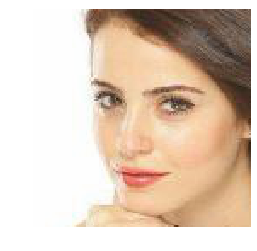

In [6]:
t0 = time.time()
z0, mse_wrt_truth = CSGM2(G=G, latentDim=latentDim, y=y, A=A, device=device, num_iter=600)

x0 = G(z0)

#grid = torchvision.utils.make_grid(x0.clamp(min=-1, max=1), scale_each=True, normalize=True)
#plt.axis('off')
#plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

net, net_input, z, alpha, beta, loss = CS_hybrid(G, net, num_channels, d_image, y, A, z_0 = z0, 
                                            latentDim=latentDim, num_iter = 1000, lr_decay_epoch = 0)

x_hat = alpha.clamp(0,1)*G(z) + beta.clamp(0,1)*(2*net(net_input.type(dtype)) - 1)

print(alpha,beta)

grid = torchvision.utils.make_grid(img_var, scale_each=True, normalize=True)
plt.axis('off')
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

t1 = time.time()
print('\n time elapsed:', t1-t0)

error_wrt_truth = mse(x_hat, img_var)
print('\nl2-recovery error:', error_wrt_truth)


save_path= 'Hybrid'+'_'+img_name+'.png'
plt.savefig(save_path,bbox_inches='tight', pad_inches = 0) 